In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

## Preliminary Data Formatting

Pulling training dataset from external CSV downloaded from Kaggle.

In [3]:
df = pd.read_csv("loan_data.csv")
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


Refortmatting the 'person_education' column to replace spaces with underscores to make single unit entries for easier processing later on.

In [4]:
df['person_education'] = df['person_education'].replace(' ','_',regex=True)
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High_School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High_School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


All types of data that the model will train on.

In [5]:
df.dtypes

person_age                        float64
person_gender                      object
person_education                   object
person_income                     float64
person_emp_exp                      int64
person_home_ownership              object
loan_amnt                         float64
loan_intent                        object
loan_int_rate                     float64
loan_percent_income               float64
cb_person_cred_hist_length        float64
credit_score                        int64
previous_loan_defaults_on_file     object
loan_status                         int64
dtype: object

Create two seperate dataframes, one that holds the Inputs (all data but final loan status) and the outputs (the final loan status). 

Model will train on Input and compare results to Output.

In [6]:
inputs = df.drop('loan_status',axis=1).copy()
inputs.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No
1,21.0,female,High_School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes
2,25.0,female,High_School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No


In [7]:
output = df['loan_status'].copy()
output.head()

0    1
1    0
2    1
3    1
4    1
Name: loan_status, dtype: int64

## Secondary Data Formatting

Now one-hot encoding will be performed on the inputs dataframe. This will allow the model to train on binary columns instead. 

loan_percent_income will also be renamed to dbt_ratio to explain its nature.

Several other combination features are also created, such as classifying "High DBTI Ratio and Low Credit Score" and "Stable Employment and Home Ownership" into their own individual categories. This helps the model find patterns faster than if it was forced to connect these dots on their own, and since these categories impact is already well defined and historical then they can be pre-determined. 

In [ ]:
inputs_encoded = pd.get_dummies(inputs, columns=['person_gender',
                                       'person_education',
                                       'person_home_ownership',
                                       'loan_intent',
                                       'previous_loan_defaults_on_file'],dtype=int)

#Debt to income ratio 
inputs_encoded.rename(columns={'loan_percent_income': 'dti_ratio'}, inplace=True)

#Related features check so we can observe dynamic relationships which can have further impact

#These preferences can be altered as per the firms personal perception of risk, and what a good dti ratio/credit score is for them
#Different firms have different internal risk aversity 
#Inputs of benchmark values for both are inputted for now

#Defining preferences for high DTI ratio and low credit score
dti_ratio_preference = 0.4
credit_score_preference = 650

inputs_encoded['high_dti_low_credit'] = (
    (inputs_encoded['dti_ratio'] > dti_ratio_preference) & 
    (inputs_encoded['credit_score'] < credit_score_preference)
).astype(int)

#Considering stable employment and homeownership as positive factors
#Full ownership and employment experience greater than 5 years

inputs_encoded['stable_homeowner'] = (
    (inputs_encoded['person_home_ownership_OWN'] == 1) & 
    (inputs_encoded['person_emp_exp'] > 5)
).astype(int)

inputs_encoded

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,dti_ratio,cb_person_cred_hist_length,credit_score,person_gender_female,person_gender_male,...,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,previous_loan_defaults_on_file_No,previous_loan_defaults_on_file_Yes,high_dti_low_credit,stable_homeowner
0,22.0,71948.0,0,35000.0,16.02,0.49,3.0,561,1,0,...,0,0,0,0,1,0,1,0,1,0
1,21.0,12282.0,0,1000.0,11.14,0.08,2.0,504,1,0,...,0,1,0,0,0,0,0,1,0,0
2,25.0,12438.0,3,5500.0,12.87,0.44,3.0,635,1,0,...,0,0,0,1,0,0,1,0,1,0
3,23.0,79753.0,0,35000.0,15.23,0.44,2.0,675,1,0,...,0,0,0,1,0,0,1,0,0,0
4,24.0,66135.0,1,35000.0,14.27,0.53,4.0,586,0,1,...,0,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.0,47971.0,6,15000.0,15.66,0.31,3.0,645,0,1,...,0,0,0,1,0,0,1,0,0,0
44996,37.0,65800.0,17,9000.0,14.07,0.14,11.0,621,1,0,...,0,0,1,0,0,0,1,0,0,0
44997,33.0,56942.0,7,2771.0,10.02,0.05,10.0,668,0,1,...,1,0,0,0,0,0,1,0,0,0
44998,29.0,33164.0,4,12000.0,13.23,0.36,6.0,604,0,1,...,0,1,0,0,0,0,1,0,0,0


Here are some more self-coded metrics we COULD use. 
However adding all of them may contribute to overfitting yet having minimal effect on the models decision making. Thus this model will stick to using the core-financial metrics and the two new ones above. 

Users are more than willing to add these relations if that is what they wish for, however for now they won't be predetermined. 

It is also likely that the model will pick up on these relationships by itself.

In [ ]:
"""

#Considering age and employment experience together

inputs_encoded['young_inexperienced'] = (
    (inputs_encoded['person_age'] < 25) & 
    (inputs_encoded['person_emp_exp'] < 2)
).astype(int)

#Small credit file (short credit history for age)

inputs_encoded['thin_credit_file'] = (
    inputs_encoded['cb_person_cred_hist_length'] < 2
).astype(int)

# High interest rates can also be a risk factor, and cause loan denial

inputs_encoded['high_interest_loan'] = (
    inputs_encoded['loan_int_rate'] > 15
).astype(int)


# Education standard: Higher education often = lower risk

inputs_encoded['advanced_degree'] = (
    (inputs_encoded['person_education_Master'] == 1) | 
    (inputs_encoded['person_education_Bachelor'] == 1)
).astype(int)


# Riskier loan purposes

inputs_encoded['risky_loan_purpose'] = (
    (inputs_encoded['loan_intent_MEDICAL'] == 1) | 
    (inputs_encoded['loan_intent_VENTURE'] == 1)
).astype(int)


# Safer loan purposes

inputs_encoded['safe_loan_purpose'] = (
    (inputs_encoded['loan_intent_HOMEIMPROVEMENT'] == 1) | 
    (inputs_encoded['loan_intent_EDUCATION'] == 1)
).astype(int)



"""

"\n\n#Considering age and employment experience together\n\ninputs_encoded['young_inexperienced'] = (\n    (inputs_encoded['person_age'] < 25) & \n    (inputs_encoded['person_emp_exp'] < 2)\n).astype(int)\n\n#Small credit file (short credit history for age)\n\ninputs_encoded['thin_credit_file'] = (\n    inputs_encoded['cb_person_cred_hist_length'] < 2\n).astype(int)\n\n# High interest rates can also be a risk factor, and cause loan denial\n\ninputs_encoded['high_interest_loan'] = (\n    inputs_encoded['loan_int_rate'] > 15\n).astype(int)\n\n\n# Education standard: Higher education often = lower risk\n\ninputs_encoded['advanced_degree'] = (\n    (inputs_encoded['person_education_Master'] == 1) | \n    (inputs_encoded['person_education_Bachelor'] == 1)\n).astype(int)\n\n\n# Riskier loan purposes\n\ninputs_encoded['risky_loan_purpose'] = (\n    (inputs_encoded['loan_intent_MEDICAL'] == 1) | \n    (inputs_encoded['loan_intent_VENTURE'] == 1)\n).astype(int)\n\n\n# Safer loan purposes\n\ninp

In [10]:
#We can make note that the outputs/loan status has two unique values: 0 and 1
#0 for not approved, 1 for approved
output.unique()

array([1, 0])

## Model Preparation 

Looking at the dataset we have prepared for training, we can see that 22.2% of people were approved. This is a very biased dataset, thus flatly training on this entire dataset could create bias in our model.

To ensure our model is trained well, we must do some prep work on the training datasets.

In [ ]:
sum(output)/len(output)

0.2222222222222222

### Creating Training and Testing Sets

- We will be splitting the training and testing sets to 75% training and 25% by not defining the test_size parameter of `sklearn`'s `train_test_split()`. This ratio can be altered by the user if needed.

- During the model's training, data from `inputs_train` and `outputs_train` will be compared to learn patterns behind the different financial characterestics of each loan request and their final status. In the end, the model is given `inputs_test` data and must predict the `output_test` values. 

- For the sake of consistency, reproducibility of results, and to ensure that model-improvements are from training and not random luck, random_state will be set to 0. Thus the splits will be consistent each time the code is run. 

- We will be ensuring that our training data is stratified. Since 22.2% of our dataset are approvals, there is a very high likelyhood of the training dataset and testing datasets are unrepresentative with the ratios. With stratify the original distrubution is mirrored. This ensures ensures that the model is trained and tested on representative data and can learn patterns effectively without bias towards the majority class (denied loans in this case). Or in general that the model doesn't train purely/more on denied loans and thus performs poorly on approved loans

In [ ]:
inputs_train, inputs_test, output_train, output_test = train_test_split(inputs_encoded, output, random_state = 0, stratify = output)

In [13]:
#Verifying that stratification worked as intended by checking proportions of approved loans in training and testing sets
print("Proportion of approved loans in training set:", sum(output_train)/len(output_train))
print("Proportion of approved loans in testing set:", sum(output_test)/len(output_test))

Proportion of approved loans in training set: 0.2222222222222222
Proportion of approved loans in testing set: 0.2222222222222222


In [14]:
##Note that we set an earlier consistent random seed of 0 for reproducibility
##This cross-validation step helps create a TEMPORARY model to assess how well our model generalizes to mixed data, and allows us to compare to the fixed set
#This can reinforce our decision to use the fixed training/testing set split above
#By testing on a few unique random splits, we can verify their average accuracy against the model we end up creating
#By ensuring that our final model performs comparably to the average of these temporary models, we can be more confident in 
# its robustness and reliability when deployed in scenarios with unseen data/which are unique

#If CV AUCPR is close to final model's AUCPR, model generalizes well, no overfitting
#If CV AUCPR is much lower than final model's AUCPR, model may be overfitting to fixed training set, or splits were uneven/lucky
#If CV AUCPR is much higher than final model's AUCPR, then something is wrong/model isn't working properly

#  Cross-validation check
print("\n" + "="*50)
print("CROSS-VALIDATION CHECK")
print("="*50)

parameters = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',  
    'seed': 0
}

dtrain_full = xgb.DMatrix(inputs_encoded, label=output)

cv_results = xgb.cv(
    params=parameters,
    dtrain=dtrain_full,
    num_boost_round=1000,
    nfold=3,
    stratified=True,
    metrics='auc',  
    early_stopping_rounds=10,
    seed=0,
    verbose_eval=False
)

print(f"\nCV Results:")
print(f"Best iteration: {len(cv_results)}")
print(f"\nCV Mean ROC-AUC: {cv_results['test-auc-mean'].iloc[-1]:.4f} "
    f"(+/- {cv_results['test-auc-std'].iloc[-1]:.4f})")


CROSS-VALIDATION CHECK

CV Results:
Best iteration: 87

CV Mean ROC-AUC: 0.9776 (+/- 0.0003)


In [15]:
#DMatrix is an optimized data structure that XGBoost uses for training and testing
#It is more efficient than standard data structures like pandas DataFrames or NumPy arrays
#It allows for faster computation and reduced memory usage during model training and evaluation
#more appropriate for large datasets and XGBoost models/its computation style

#Converting training and testing data to DMatrix format
datatrain = xgb.DMatrix(inputs_train, label=output_train)
datatest = xgb.DMatrix(inputs_test, label=output_test)


#'objective': 'binary:logistic'` specifies that we are performing binary classification (0 or 1 for denied/approved loans)
#'eval_metric': 'aucpr'` indicates that we want to use the Area Under the Precision-Recall Curve (AUC-PR) as our evaluation metric
#This metric is particularly useful for imbalanced datasets like ours, as it focuses on the performance of the positive class (approved loans)
#It can measure how well the model distinguishes between approved and denied loans, within a given tree/section of the dataset
#i.e the model will run on 1000 cases for a given tree, and calculate the AUC-PR for those 1000 cases to evaluate performance
#Measuring the precision of the model in predicting approved loans within that subset


parameters = {
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
    'seed': 0
}

##Early stopping is used to prevent overfitting during training, where the model starts to memorize the training data instead of learning general patterns
##Furthermore once the model's performance on the training data stales, and the aucpr scores begin to equal, if they don't improve for 10 consecutive rounds
##the training process is halted to avoid overfitting and unnecessary computation

##num_boost_round=1000 specifies that the model can train for up to 1000 boosting rounds (trees) if needed
##However, with early stopping in place, the training may stop earlier if no improvement is observed in the evaluation metric on the test set for 10 consecutive rounds

#evals=[(datatest, 'eval')] - Evaluate performance on the test set after each tree is added (monitors how well it generalizes)


model = xgb.train(parameters,datatrain,num_boost_round=1000,evals=[(datatest, 'eval')],early_stopping_rounds=10,verbose_eval=True)

#So using xgb.train() with those parameters allows us to train an XGBoost model for binary classification on our loan approval dataset
#It creates an ensemble of decision trees which make up the thinking process of the model
#This decsion tree structure defines the model's logic for predicting loan approval status based on input features, for future application

#In our case as we see below, the model created 105 trees for decsion making


[0]	eval-aucpr:0.88724
[1]	eval-aucpr:0.90243
[2]	eval-aucpr:0.90745
[3]	eval-aucpr:0.91352
[4]	eval-aucpr:0.91582
[5]	eval-aucpr:0.91753
[6]	eval-aucpr:0.91894
[7]	eval-aucpr:0.92070
[8]	eval-aucpr:0.92115
[9]	eval-aucpr:0.92281
[10]	eval-aucpr:0.92354
[11]	eval-aucpr:0.92497
[12]	eval-aucpr:0.92562
[13]	eval-aucpr:0.92631
[14]	eval-aucpr:0.92694
[15]	eval-aucpr:0.92753
[16]	eval-aucpr:0.92894
[17]	eval-aucpr:0.92949
[18]	eval-aucpr:0.93016
[19]	eval-aucpr:0.93032
[20]	eval-aucpr:0.93073
[21]	eval-aucpr:0.93110
[22]	eval-aucpr:0.93130
[23]	eval-aucpr:0.93178
[24]	eval-aucpr:0.93209
[25]	eval-aucpr:0.93223
[26]	eval-aucpr:0.93206
[27]	eval-aucpr:0.93242
[28]	eval-aucpr:0.93243
[29]	eval-aucpr:0.93276
[30]	eval-aucpr:0.93403
[31]	eval-aucpr:0.93617
[32]	eval-aucpr:0.93634
[33]	eval-aucpr:0.93629
[34]	eval-aucpr:0.93658
[35]	eval-aucpr:0.93669
[36]	eval-aucpr:0.93793
[37]	eval-aucpr:0.93782
[38]	eval-aucpr:0.93862
[39]	eval-aucpr:0.93880
[40]	eval-aucpr:0.93893
[41]	eval-aucpr:0.93944
[4

In [16]:
#Here is where we use the trained model to make predictions on the test dataset
#trained model looks at each loan in the test set and outputs a probability of it being an approved loan (a number between 0 and 1).

output_probability = model.predict(datatest)

#-------------------------------------------------------------------------------------------------------------------------------------------

#The gini coefficient is a commonly used metric in credit risk modeling to determine the quality of a model
#In regards to its ability to distinguish between good and bad borrowers, discriminatory power
#Ranges from -1 to 1, 1 = perfect discrimination, 0 = no discrimination (random guessing), negative values indicating worse than random performance

# Calculate Gini score (INdustry standard metric for credit risk models))
roc_auc = roc_auc_score(output_test, output_probability)
gini = 2 * roc_auc - 1

print(f"\nGini Coefficient: {gini:.4f}")
print(f"  Industry Benchmark is typically: >0.50 Good | >0.60 Excellent")
print(f"  Result: {'EXCELLENT MODEL' if gini > 0.60 else 'GOOD MODEL' if gini > 0.50 else 'NEEDS IMPROVEMENT'}")

#--------------------------------------------------------------------------------------------------------------------------------------------

#Once we use our model/trained decision trees to predict probabilities, we need to convert those probabilities 
# into binary predictions (0 or 1 for denied/approved loans)

#In general the threshold is dependent on the buisness/company/loaners personal risk aversity
#If you set a higher threshold (e.g., 0.7), the model will be more conservative in approving loans, leading to fewer approvals but potentially lower default rates
#Because you want to only take on loans that the model is very confident about being approved

#If you set a lower threshold (e.g., 0.3), the model will be more lenient in approving loans, resulting in more approvals but potentially higher default rates
#Because you are willing to take on more risk and approve loans even when the model is less certain about their approval status

arb_optimal_threshold = 0.5  #This can be adjusted based on risk preference

output_prediction1 = np.where(output_probability >= arb_optimal_threshold, 1, 0)

print ("Here were the output probabilities:", output_probability)
print("\n" + "="*50)
print(output_prediction1)
print(f"\nUsing arbitrary threshold of {arb_optimal_threshold}:")

#-------------------------------------------------------------------------------------------------------------------------------------------

#However this threshold can be optimized based on the model's performance on the test set, mathematically
#One common method is to use the Kolmogorov-Smirnov (KS) statistic
#This method identifies the threshold that maximizes the difference between the true positive rate (TPR) and false positive rate (FPR)
#This optimal threshold balances sensitivity and specificity, improving the model's overall classification performance

#This isn't always the most ideal method, as different people have different preferences for risk aversity/goals
#However it provides a solid mathematically derived starting point for threshold selection. 

#As per our data we can understand that this method brings out a threshold which is much more aggresive in loan approvals
# This is because our dataset has only 22% approval rate (class imbalance),
# so the KS-optimal point occurs at a lower threshold than the intuitive 0.5

#To determine the mathematically optimal threshold, we must use ROC curve analysis, and the data we have from inputs/outputs

fpr, tpr, thresholds = roc_curve(output_test, output_probability)
ks_stat = max(tpr - fpr)
ks_optimal_threshold = thresholds[np.argmax(tpr - fpr)]

output_prediction2 = np.where(output_probability >= ks_optimal_threshold, 1, 0)
print("\n" + "="*50)
print(output_prediction2)
print(f"\nUsing KS optimal threshold of {ks_optimal_threshold:.3f}:")




Gini Coefficient: 0.9587
  Industry Benchmark is typically: >0.50 Good | >0.60 Excellent
  Result: EXCELLENT MODEL
Here were the output probabilities: [3.9070436e-01 3.8109192e-07 4.5350239e-01 ... 3.3466184e-01 2.5339559e-05
 9.9968350e-01]

[0 0 0 ... 0 0 1]

Using arbitrary threshold of 0.5:

[1 0 1 ... 1 0 1]

Using KS optimal threshold of 0.198:


In [17]:
print("Class Distribution:")
print(f"Total samples: {len(output)}")
print(f"Approved (1): {sum(output)} ({sum(output)/len(output)*100:.1f}%)")
print(f"Denied (0): {len(output) - sum(output)} ({(len(output)-sum(output))/len(output)*100:.1f}%)")

Class Distribution:
Total samples: 45000
Approved (1): 10000 (22.2%)
Denied (0): 35000 (77.8%)


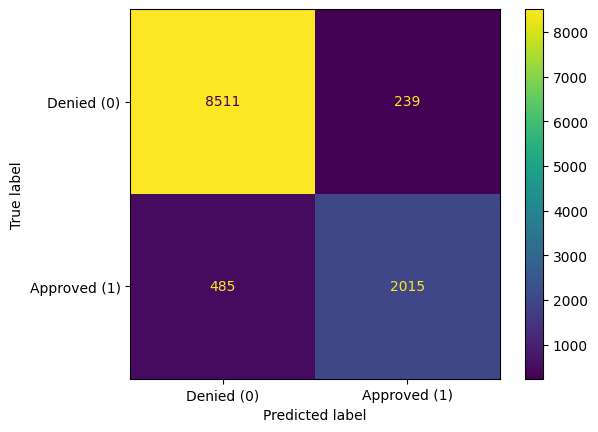

In [18]:
#FIRST
#Confusion Matrix Display for final model with arbitrary threshold (0.5)

conf_matr = confusion_matrix(output_test, output_prediction1)
ConfusionMatrixDisplay(confusion_matrix=conf_matr, display_labels=["Denied (0)", "Approved (1)"]).plot()

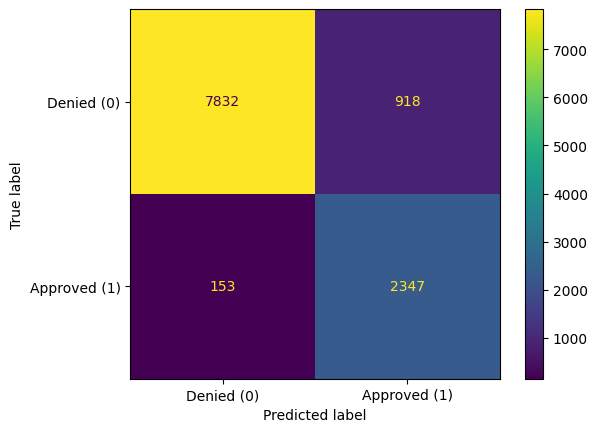

In [19]:
#Second
#Confusion Matrix Display for final model with KS optimal threshold

conf_matr = confusion_matrix(output_test, output_prediction2)
ConfusionMatrixDisplay(confusion_matrix=conf_matr, display_labels=["Denied (0)", "Approved (1)"]).plot()

In [20]:
#Results for model using arbitrary threshold/reasonable threshold (0.5)
print("\n" + "="*50)
print("CLASSIFICATION REPORT FOR MODEL USING ARBITRARY THRESHOLD (0.5)")
print (classification_report(output_test, output_prediction1))

#Results for model using KS optimal threshold
print("\n" + "="*50)
print("CLASSIFICATION REPORT FOR MODEL USING KS OPTIMAL THRESHOLD")
print (classification_report(output_test, output_prediction2))


CLASSIFICATION REPORT FOR MODEL USING ARBITRARY THRESHOLD (0.5)
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      8750
           1       0.89      0.81      0.85      2500

    accuracy                           0.94     11250
   macro avg       0.92      0.89      0.90     11250
weighted avg       0.93      0.94      0.93     11250


CLASSIFICATION REPORT FOR MODEL USING KS OPTIMAL THRESHOLD
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      8750
           1       0.72      0.94      0.81      2500

    accuracy                           0.90     11250
   macro avg       0.85      0.92      0.88     11250
weighted avg       0.92      0.90      0.91     11250

